In [30]:
library(data.table)
library(dplyr)
library(UpSetR)
library(ggvenn)
library(graphics)
library(ggforce)
library(ggsci)
library(scales)
library(ComplexHeatmap)
library(ggpubr)
library(ggplot2)
library(pbapply)
source("./eMut/R/function/functions.R")

# 1.SNV extraction

In [50]:
samples<-c("ALL",paste0("AML",1:10))
SNVDF.list<-lapply(samples,function(sam){
    baseDir<-paste0("./Monopogen/",sam,"/")
    dir<-paste0(baseDir,"somatic")
    SNV.df<-SNVExtract(dir)
    if(!is.null(SNV.df)){
       SNV.df$sample<-rep(sam,nrow(SNV.df))
       SNV.df  
    }
})
names(SNVDF.list)<-samples
SNV.df<-rbindlist(SNVDF.list)
SNV.df<-SNV.df[,c(1:4,13,5:12,14)]
names(SNV.df)[1:5]<-c("CHROM","POS","REF","ALT","ID")

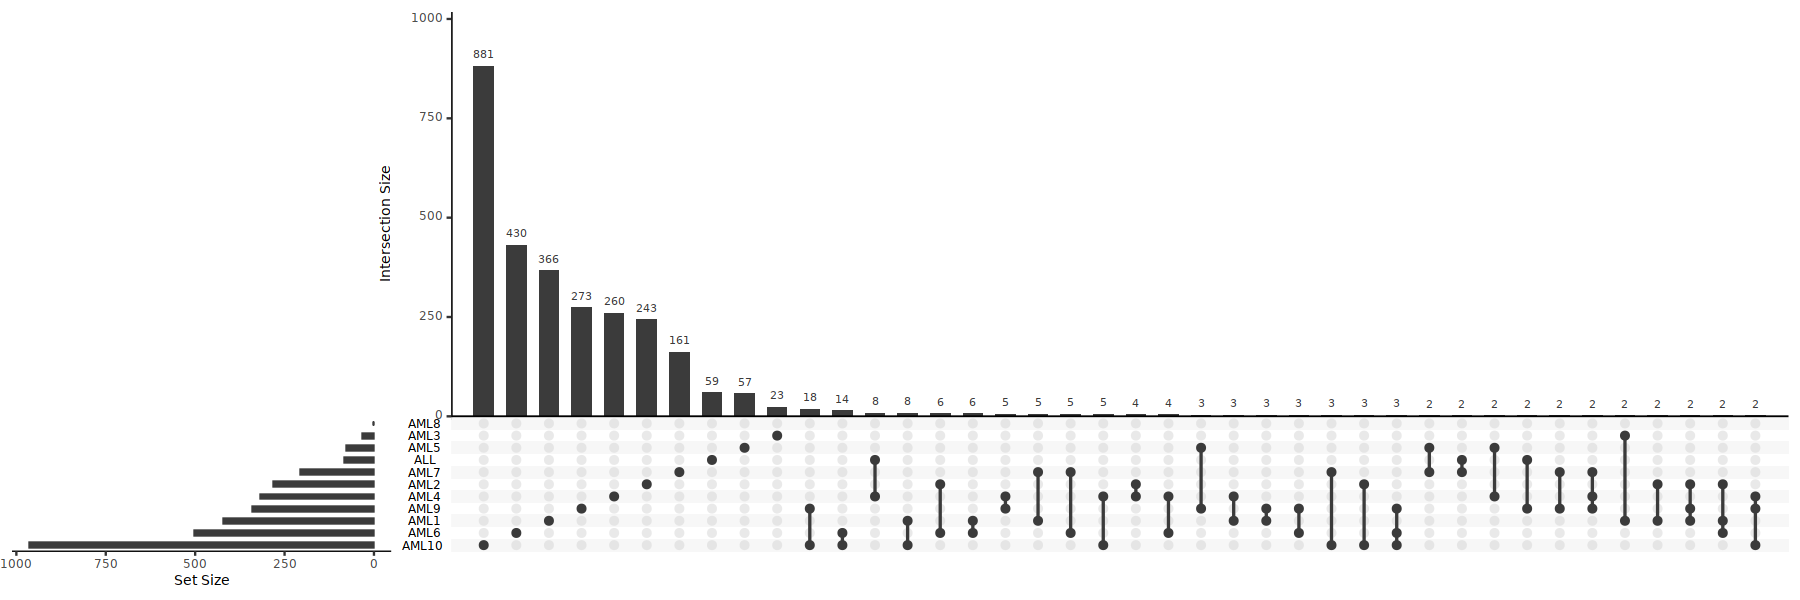

In [30]:
options(repr.plot.width = 15, repr.plot.height = 5)
mut.list<-lapply(samples,function(x){
    SNVDF.list[[x]]$mut
})
names(mut.list)<-samples
upset(fromList(mut.list), order.by = "freq",nsets=13)

In [31]:
SNV<-unique(SNV.df$ID)
SNV.sam<-matrix(0,length(unique(SNV)),length(unique(SNV.df$sample)),dimnames=list(unique(SNV),unique(SNV.df$sample)))
for(i in 1:nrow(SNV.df)){
    SNV.sam[SNV.df$ID[i],SNV.df$sample[i]]<-1
}
str(SNV.sam)

 num [1:2937, 1:10] 1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:2937] "chr1;1780416;G;A" "chr1;3900826;C;G" "chr1;16889487;C;A" "chr1;16896253;G;C" ...
  ..$ : chr [1:10] "ALL" "AML1" "AML2" "AML3" ...


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



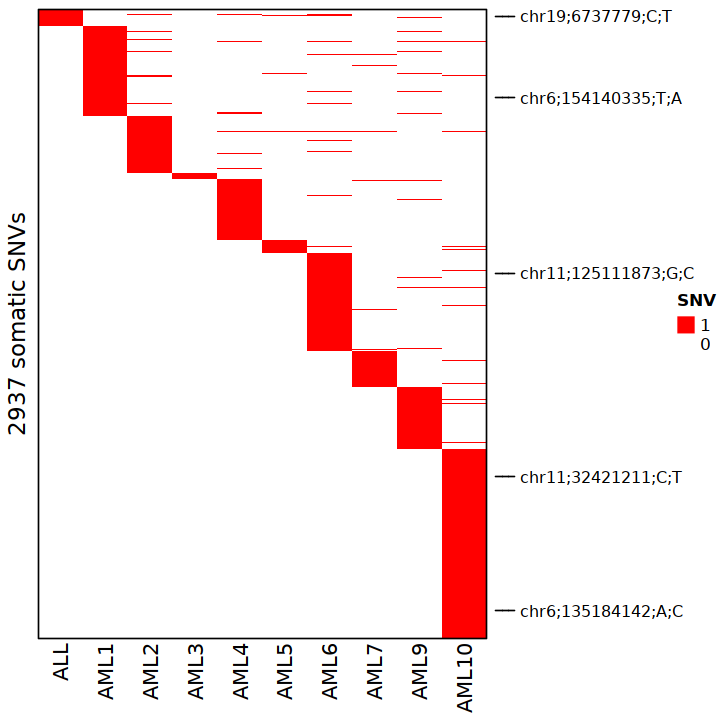

In [32]:
options(repr.plot.width = 6, repr.plot.height = 6)
p<-Heatmap(SNV.sam, show_column_names =TRUE, show_row_names = FALSE,
        cluster_rows = FALSE, cluster_columns = FALSE, show_column_dend = F,
        raster_quality = 2,use_raster = TRUE,
        col = c("white","red"),
        border = TRUE,
        row_title = "2937 somatic SNVs",
        heatmap_legend_param = list(title="SNV"))
p<-p+rowAnnotation(link = anno_mark(at =c(33,414,1234,2184,2809), 
                                  labels = row.names(SNV.sam)[c(33,414,1234,2184,2809)], labels_gp = gpar(fontsize = 9)))
p

In [ ]:
######     for mutation annotation
write.table(SNV.df,file="./Monopogen/summary/SNV.vcf",col.names=T,row.names=F,quote=F,sep="\t")

In [38]:
############################   combined mutation matrix  ###########################################
samples<-c("ALL",paste0("AML",1:10))
mat.list<-lapply(samples,function(sam){
    baseDir<-paste0("/./Monopogen/",sam,"/")
    dir<-paste0(baseDir,"somatic")
    mat<-SNVMatrix(dir)
})
names(mat.list)<-samples

###  combine SNV matrixs of AML samples
SNVs<-sapply(mat.list,function(x){ row.names(x)}) %>% unlist() %>% unique()
cells<-sapply(mat.list,function(x){ colnames(x)}) %>% unlist() %>% unique()
mat<-matrix("0/0",nrow=length(SNVs),ncol=length(cells),dimnames=list(SNVs,cells))
for(i in setdiff(samples,"AML8")){
    tmp<-mat.list[[i]]
    mat[row.names(tmp),colnames(tmp)]<-tmp
}

In [39]:
str(mat)

 chr [1:2937, 1:69889] "0/0" "0/0" "0/0" "0/0" "0/0" "0/0" "0/0" "0/0" ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:2937] "chr1:1780416:G:A" "chr1:3900826:C:G" "chr1:16889487:C:A" "chr1:16896253:G:C" ...
  ..$ : chr [1:69889] "AML8#ACCACTGTACTATGCACAACCACA" "AML8#ATCCTGTAAGATGTACGAGTTAGC" "AML8#CAGCGTTACCGTGAGAAGATGTAC" "AML8#CCTCCTGAAGAGTCAAGCGAGTAA" ...


In [ ]:
save(mat,file="./Monopogen/summary/SNVMat.Rdata")

# 2.Imputation

## 1) mutaion imputation

In [2]:
# input option1 (peak-by-cell matrix)
load("./ArchR/TileMatrix.Rdata") 
row.names(count)<-paste("peaks",1:nrow(count),sep="-")

# input option2  (m-knn graph)
load("./Monopogen/summary/mutualknn30.Rdata") 

Loading required package: Matrix



In [ ]:
TRS.list<-SNVImputation(countMatrix=NULL,
                        knnGraph=mutualknn30,
                        SNVMatrix=mat,
                        mutations=row.names(mat),
                        numk=30,
                        queryCell_cutoff=5,
                        ncors=5)

## 2) umap of imputation

In [12]:
proj<- loadArchRProject(path = "./projects/aml/summary/ArchR", force = FALSE, showLogo = FALSE)
UMAP.loc<-proj@embeddings@listData$UMAP@listData$df
row.names(UMAP.loc)<-proj@embeddings@listData$UMAP@listData$params$projectID@rownames
colnames(UMAP.loc)<-c("UMAP1","UMAP2")

Successfully loaded ArchRProject!



Warning message:
“Removed 60 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 60 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 60 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 60 rows containing missing values (`geom_point()`).”


NULL

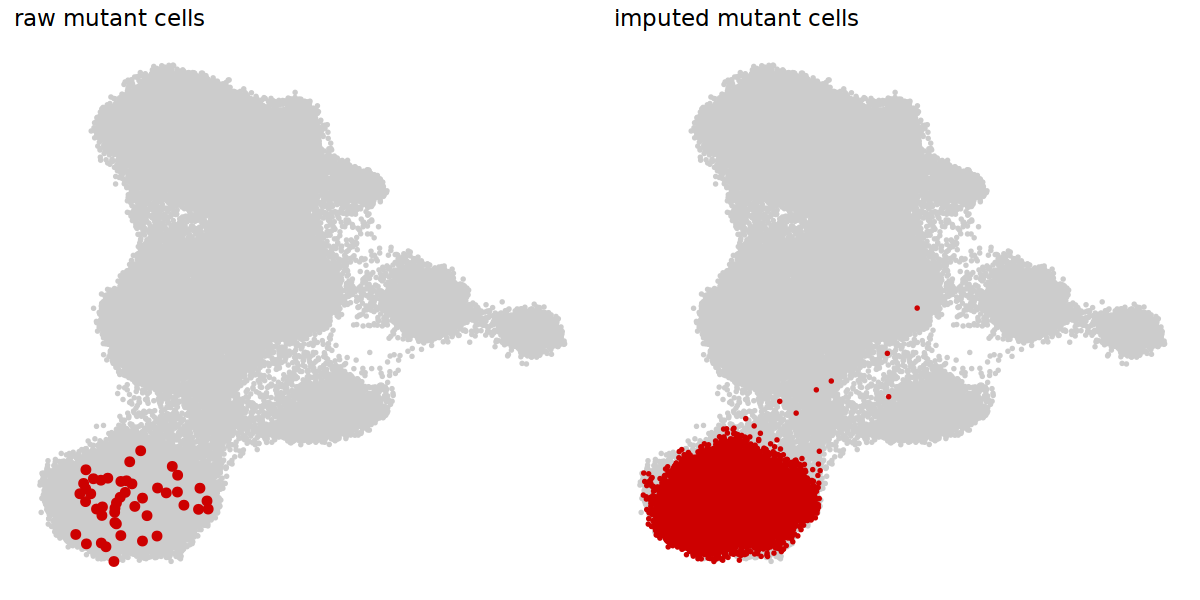

In [19]:
options(repr.plot.width = 10, repr.plot.height =5)
p<-UMAPImputation(UMAP.loc,TRS.list[["chr11:32421211:C:T"]])
p

# 3.Cell type enrichment

##   1) raw mutant cells

In [ ]:
library(ArchR)

In [38]:
cells<-row.names(getCellColData(proj))
cellTypes<-proj$NamedClust

mut.type<-pblapply(row.names(mat),function(x){
    mutCells<-colnames(mat)[which(mat[x,]=="0/1" | mat[x,]=="1/1")]
    result<-cellTypeEnrich(cells,
                         cellTypes,
                         mutCells,
                         mutCells_cutoff=50,
                         cellType_cutoff=50)
    if(!is.null(result)){
      result$mut<-rep(x,nrow(result))
      result  
    }
}) %>% rbindlist()
mut.type$p<-p.adjust(mut.type$p)

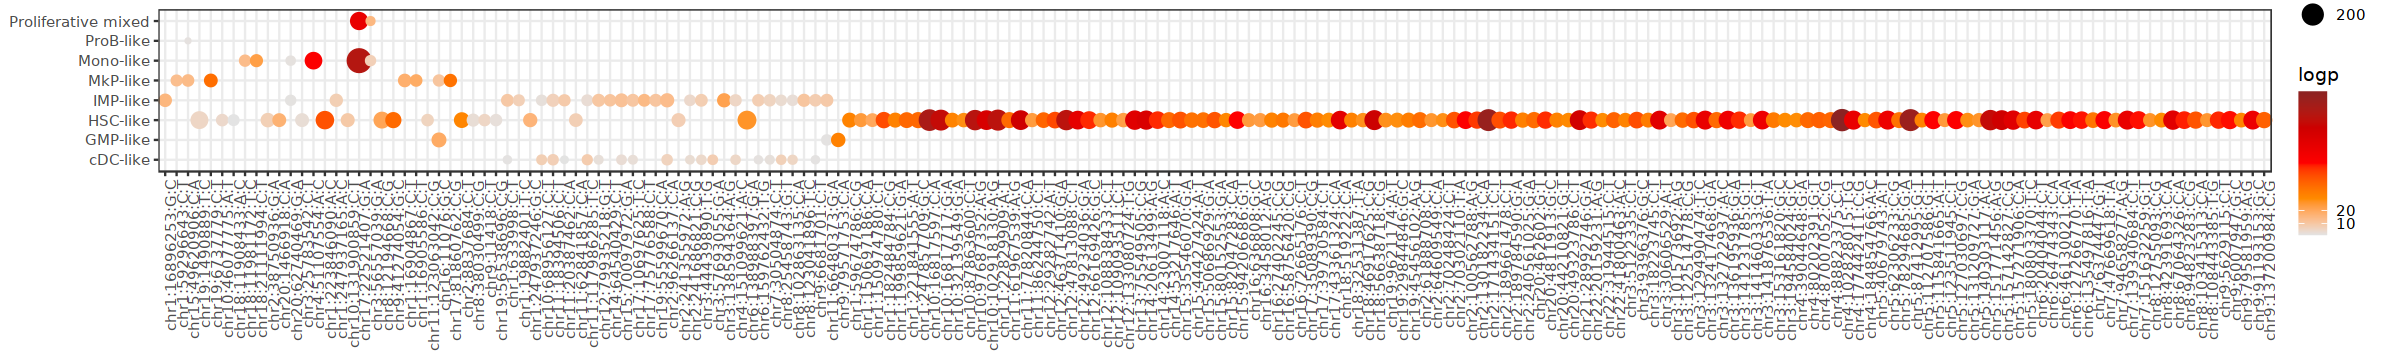

In [41]:
options(repr.plot.width = 20, repr.plot.height = 3)
mut.type$logp<-log10(1/(mut.type$p))
mut.type$logp[is.infinite(mut.type$logp)]<-max(mut.type$logp[!is.infinite(mut.type$logp)])
mut.type<-mut.type[mut.type$p<0.05,]
union.mut<-mut.type$mut[mut.type$p<0.05] %>% unique()
mut.type<-mut.type[mut.type$p<0.05,]

p<-ggplot(mut.type,aes(x=factor(mut,union.mut),y=types))+
  geom_point(aes(size=mut.num,color=logp))+
  labs(x=NULL,y=NULL)+
  theme_bw()+
  theme(axis.text.x=element_text(angle=90,hjust=1))+
  scale_color_gradientn(colors = c("gray89","darkorange","red","red3","brown4"),
                        breaks = c(0,1.3,10,20,300))
p

##  2) imputed mutant cells

In [46]:
mut.type<-pblapply(names(TRS.list)[1:50],function(x){
    mutCells<-row.names(TRS.list[[x]])[TRS.list[[x]]$true_cell_top_idx==TRUE]
    result<-cellTypeEnrich(cells,
                         cellTypes,
                         mutCells,
                         mutCells_cutoff=50,
                         cellType_cutoff=50)
    if(!is.null(result)){
      result$mut<-rep(x,nrow(result))
      result  
    }
}) %>% rbindlist()
mut.type$p<-p.adjust(mut.type$p)

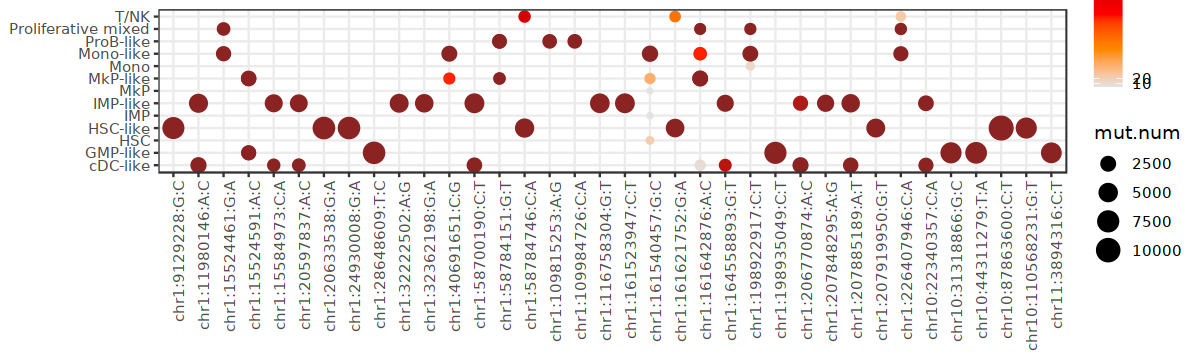

In [47]:
options(repr.plot.width = 10, repr.plot.height = 3)
mut.type$logp<-log10(1/(mut.type$p))
mut.type$logp[is.infinite(mut.type$logp)]<-max(mut.type$logp[!is.infinite(mut.type$logp)])
mut.type<-mut.type[mut.type$p<0.05,]
union.mut<-mut.type$mut[mut.type$p<0.05] %>% unique()
mut.type<-mut.type[mut.type$p<0.05,]

p<-ggplot(mut.type,aes(x=factor(mut,union.mut),y=types))+
  geom_point(aes(size=mut.num,color=logp))+
  labs(x=NULL,y=NULL)+
  theme_bw()+
  theme(axis.text.x=element_text(angle=90,hjust=1))+
  scale_color_gradientn(colors = c("gray89","darkorange","red","red3","brown4"),
                        breaks = c(0,1.3,10,20,300))
p

# 4. hyperMutated CREs

##  1) load modified functions

In [48]:
library(ActiveDriverWGS)
library(tidyr)
library(BSgenome.Hsapiens.UCSC.hg38)
source("/eMut/R/function/ADWGS_test.r")
source("/eMut/R/function/activeDriverWGS.r")
source("/eMut/R/function/fix_all_results.r")

Warning message:
“package ‘ActiveDriverWGS’ was built under R version 4.2.2”

Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


The following object is masked from ‘package:S4Vectors’:

    expand


The following object is masked from ‘package:magrittr’:

    extract


Warning message:
“package ‘BSgenome.Hsapiens.UCSC.hg38’ was built under R version 4.2.2”
Loading required package: BSgenome

Warning message:
“package ‘BSgenome’ was built under R version 4.2.2”
Loading required package: Biostrings

Warning message:
“package ‘Biostrings’ was built under R version 4.2.2”
Loading required package: XVector

Warning message:
“package ‘XVector’ was built under R version 4.2.1”

Attaching package: ‘XVector’


The following object is masked from ‘package:plyr’:

    compact



Attaching package: ‘Biostrings’


The following object is masked from ‘package:grid’:

    pattern


The following object is masked from ‘package:base’:

    

##   2) load mutations

In [ ]:
########   load mutations
samples<-c("BM83_nor","BM89_M5","BM90_M2a","BM93_M1","BM94_ALL","BM95_M5b","BM134_M2a","BM136_M4M5","BM140_M5","BM156_M5",
           "BM83_nor1","BM159_M2a","BM141_x","BM155_nor")
cellMut<-lapply(samples,function(x){
  df<-data.table::fread(
    file = paste0("./2.GATK/all-scATAC/",x,".maf"),
    sep = "\t",stringsAsFactors = FALSE,verbose = FALSE,data.table = TRUE,
    showProgress = TRUE,header = TRUE,fill = TRUE,
    skip =1,quote = "")
  df<-df[df$FILTER=="PASS",]
  df<-df[,c("Chromosome","Start_Position","End_Position",
                             "Reference_Allele","Tumor_Seq_Allele2","Tumor_Sample_Barcode")]
  colnames(df)<-c("chr","pos1","pos2","ref","alt","patient")
  df<-df[df$chr!="chrM",]
  })
names(cellMut)<-samples

##   3)laod peaks

In [ ]:
#######  laod peaks
peaks.df<-read.table("./2.GATK/all-scATAC/peaks.bed",header=F,quote="",sep="\t")
colnames(peaks.df)<-c("chr","start","end","id")
peaks.df<-peaks.df[peaks.df$chr!="chrM",]
peaks.df$start<-as.numeric(peaks.df$start)
peaks.df$end<-as.numeric(peaks.df$end)
openRegions<-GenomicRanges::GRanges(seqnames=peaks.df$chr, 
                                    IRanges::IRanges(peaks.df$start,peaks.df$end))
openRegions<-GenomicRanges::union(openRegions,openRegions)

In [ ]:
##   4) identify hyperMutated CREs

In [ ]:
hyperMutatedPeaks<-pblapply(samples,function(x){
  mutations<-cellMut[[x]]

  hyperMut<-ActiveDriverWGS(mutations = mutations,
                            elements = peaks.df,
                            ref_genome = "hg38",
                            mc.cores=4,
                            window_size=1000000,  ### 窗口要大一些
                            detect_depleted_mutations=FALSE,
                            openRegions = openRegions,
                            recovery.dir=paste0("./3.driverEnhancer/tmp/",x))
  save(hyperMut,file=paste0("./3.driverEnhancer/",x,"_window1000kb_hyperMut.Rdata"))
})

# 5.prediction of TF binding motif change

In [63]:
library(motifbreakR)
library(MotifDb)
library(dplyr)
library(BSgenome.Hsapiens.UCSC.hg38)
library(data.table)

##  1) SNV mutations format

In [71]:
mut<-data.frame(Chromosome=SNV.df$CHROM,Start_Position=SNV.df$POS-1,End_Position=SNV.df$POS,
                names=gsub(";",":",SNV.df$ID),score=rep(0,nrow(SNV.df)),strand=rep("+",nrow(SNV.df)))
mut<-mut %>% distinct(names,.keep_all = TRUE)

write.table(mut,file="./Monopogen/summary/SNVsForMotifBreakR.bed",sep="\t",
            col.names = F,row.names = F,quote=F)

##   2)prediction of TF-binding motifs

In [69]:
data(motifbreakR_motif)
ENCODE<-subset (motifbreakR_motif, dataSource=="ENCODE-motif" & organism=="Hsapiens")
snps.mb.frombed <- snps.from.file(file = "./Monopogen/summary/SNVsForMotifBreakR.bed",
                                  search.genome = BSgenome.Hsapiens.UCSC.hg38,
                                  format = "bed")

SNV.motifs <- motifbreakR(snpList = snps.mb.frombed, filterp = TRUE,
                       pwmList = ENCODE,
                       threshold = 1e-4,
                       method = "ic",
                       bkg = c(A=0.25, C=0.25, G=0.25, T=0.25),
                       BPPARAM = BiocParallel::MulticoreParam(5))

# 6.Comparsion gene expression of target gene between mutant cells/samples and wild-type ones

##  1) gene expression

In [76]:
data <- as.data.frame(read.csv("./projects/aml/bulk_RNA/GeneExpressionMatrix.csv", row.names = "Geneid"))
sample <- factor(colnames(data), levels = stringr::str_sort(colnames(data), numeric = TRUE))
df = read.table("./projects/aml/bulk_RNA/BM159_3/counts.txt", header = T, row.names = 1)
df_length = as.data.frame(df[row.names(data),'Length']/1000)
colnames(df_length) = 'len'
rpk = data/df_length$len
tpm = t(t(rpk)/colSums(rpk) * 1000000)

##    2)SNV and their annotation

In [77]:
SNV.df<-read.table("./Monopogen/summary/SNV.vcf",header=T,sep="\t",fill=T,comment.char = "!")
load("./project/Database/Work/Alz/eNet/hg38_refSeq.RData")
AML.genes<-read.table("./AML-specific/AML-genes.txt",header=T,sep="\t")[,1]
names(hg38TSSRanges) <- as.character(hg38TSSRanges$gene_name)
TSSg<-hg38TSSRanges

In [78]:
SNV.anno<-read.table("./Monopogen/summary/SNV_anno.txt",header=T,sep="\t",fill=T,quote="")
SNV.anno<-SNV.anno[SNV.anno$Gene.Name!="",]
SNV.anno[,1]<-sapply(strsplit(SNV.anno[,1],"-"),function(x){x[1]})
SNV.anno<-SNV.anno[SNV.anno$Gene.Name %in% row.names(tpm),]
SNV.anno<-SNV.anno[!duplicated(SNV.anno[,1]),]

##     3) target gene expression between mutant samples and wild type ones

In [79]:
result<-pblapply(1:nrow(SNV.anno),function(x){
  mut<-SNV.anno[x,1]
  gene<-SNV.anno$Gene.Name[x]
  mut.sample<-SNV.df$sample[SNV.df$ID==mut] %>% unique()
  RNA.sample<-sapply(strsplit(colnames(tpm),split = "_"),function(x){x[[1]]}) %>% unlist()
  mut.exp<-tpm[gene,RNA.sample %in% mut.sample] %>% t() %>% as.vector()
  nonMut.exp<-tpm[gene,!RNA.sample %in% mut.sample] %>% t() %>% as.vector()
  p<-wilcox.test(mut.exp,nonMut.exp)$p.value
  foldchange<-mean(mut.exp)/mean(nonMut.exp)   
  ####   plot 
  if(p<0.05){
       plot.df<-data.frame(exp=c(mut.exp,nonMut.exp),
                           sample=c(RNA.sample[RNA.sample %in% mut.sample],RNA.sample[!RNA.sample %in% mut.sample]),
                           lable=rep(c("MUT","WT"),c(length(mut.exp),length(nonMut.exp))))
       pdf(paste0("./figures/monopogen/mutExp/closetGene/",gene,";",mut,".pdf"),height=4,width=4)
       figure<-ggplot(plot.df,aes(x=lable,y=exp))+geom_boxplot()+
         geom_jitter(width=0.3,aes(color=sample))+
         stat_compare_means(method = "wilcox.test")+
         theme_bw()+labs(title=paste(gene,mut,sep=":"))+
         theme(axis.title = element_text(size = 15))
       print(figure)
       dev.off()
      }
      ####   return
  data.frame(gene=gene,mutation=mut,mutSamples=paste(mut.sample,collapse = ";"),pValue=p,foldchange=foldchange)
}) %>% rbindlist()
result$adjsP<-p.adjust(result$pValue,method="fdr")

Warning message in wilcox.test.default(mut.exp, nonMut.exp):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(mut.exp, nonMut.exp):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(mut.exp, nonMut.exp):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(mut.exp, nonMut.exp):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(mut.exp, nonMut.exp):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(mut.exp, nonMut.exp):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(mut.exp, nonMut.exp):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(mut.exp, nonMut.exp):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(mut.exp, nonMut.exp):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(mut.exp, nonMut.exp):
"cannot compute exact

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



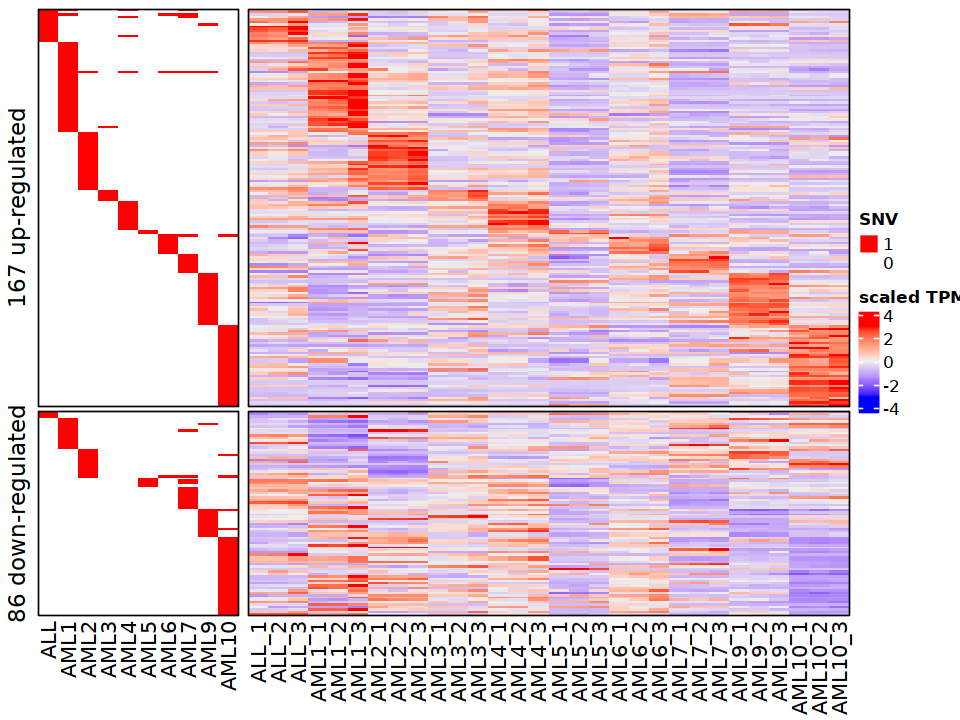

In [81]:
options(repr.plot.width = 8, repr.plot.height = 6)
SNV<-unique(SNV.df$ID)
SNV.sam<-matrix(0,length(unique(SNV)),length(unique(SNV.df$sample)),dimnames=list(unique(SNV),unique(SNV.df$sample)))
for(i in 1:nrow(SNV.df)){
    SNV.sam[SNV.df$ID[i],SNV.df$sample[i]]<-1
}
SNV.flt<-rbind(SNV.sam[row.names(SNV.sam) %in% result$mutation[result$adjsP<0.05 & result$foldchange>1],],
               SNV.sam[row.names(SNV.sam) %in% result$mutation[result$adjsP<0.05 & result$foldchange<1],])
p1<-Heatmap(SNV.flt, show_column_names =TRUE, show_row_names = FALSE,
        cluster_rows = FALSE, cluster_columns = FALSE, show_column_dend = F,
        raster_quality = 2,use_raster = TRUE,
        col = c("white","red"),
        border = TRUE,
        row_split=rep(c("167 up-regulated","86 down-regulated"),c(length(which(result$adjsP<0.05 & result$foldchange>1)),length(which(result$adjsP<0.05 & result$foldchange<1)))),
        #row_title = "214 somatic SNVs",
        heatmap_legend_param = list(title="SNV"))

###  expression heatmap
tpm.flt<-tpm[result$gene[match(row.names(SNV.flt),result$mutation)],]
tpm.flt<-apply(tpm.flt,1,function(x){scale(x)}) %>% t()
colnames(tpm.flt)<-colnames(tpm)
p2<-Heatmap(tpm.flt[,paste(rep(colnames(SNV.flt),each=3),rep(1:3,times=10),sep="_")], show_column_names =TRUE, show_row_names = FALSE,
        cluster_rows = FALSE, cluster_columns = FALSE, show_column_dend = F,
        raster_quality = 2,use_raster = TRUE,
        border = TRUE,
        #col=c("#352A86","#343DAE","#0262E0","#1389D2","white","#A5BE6A","#F8BA43","#F6DA23","#F8FA0D"),
        row_split=rep(c("167 up-regulated","86 down-regulated"),c(length(which(result$adjsP<0.05 & result$foldchange>1)),length(which(result$adjsP<0.05 & result$foldchange<1)))),
        #row_title = "214 up-regulated somatic SNVs",
        heatmap_legend_param = list(title="scaled TPM"))
p1+p2